In [12]:
import os
from datetime import datetime
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
#from osgeo import gdal
import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
import pyproj
from pyproj import Proj
from shapely.ops import transform
import xarray as xr
#import geoviews as gv
#from cartopy import crs
import hvplot.xarray
import holoviews as hv
import boto3
from rasterio.session import AWSSession

In [13]:
# Find last page
base_url = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/MYD13Q1.v061/items/'
collections_response = r.get(base_url, verify=False).json()
total_items = collections_response['numberMatched']
items_returned = collections_response['numberReturned']
last_page = total_items // items_returned
if total_items % items_returned != 0:
    last_page += 1
last_page_url = base_url + f"?page={last_page}"
print(last_page_url)
# https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/MYD13Q1.v061/items/?page=11229
last_response = r.get(last_page_url, verify=False).json()

for i in last_response['features']:
    print(i['assets']['browse']['href'])

c:\Users\cinfante\OneDrive - NRCan RNCan\Documents\Greenup\NASA-LPDAAC-Testing\venv\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmr.earthdata.nasa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/MYD13Q1.v061/items/?page=14111


c:\Users\cinfante\OneDrive - NRCan RNCan\Documents\Greenup\NASA-LPDAAC-Testing\venv\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmr.earthdata.nasa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/MYD13Q1.061/MYD13Q1.A2023201.h21v07.061.2023219223659/BROWSE.MYD13Q1.A2023201.h21v07.061.2023219223659.1.jpg
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/MYD13Q1.061/MYD13Q1.A2023201.h26v05.061.2023219223718/BROWSE.MYD13Q1.A2023201.h26v05.061.2023219223718.1.jpg


In [24]:
# Perform a search
lp_search = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search'

params = {}

# Set a limit
lim = 100
params['limit'] = lim  # Add in a limit parameter to retrieve 100 items at a time.

# Set the bounding box
field = gp.read_file('Field_Boundary.geojson')
fieldShape = field['geometry'][0]
#bbox = f'{fieldShape.bounds[0]},{fieldShape.bounds[1]},{fieldShape.bounds[2]},{fieldShape.bounds[3]}'    # Defined from ROI bounds
bbox = '-141.00275,41.6751050889,-52.3231986987,83.6751'
print(bbox)
params['bbox'] = bbox 

# Choose your collection
collection = "MYD13Q1.v061"
params["collections"] = [collection]

# Set the time
date_time = "2023-07-21T00:00:00Z/2023-08-21T23:59:59Z"
params['datetime'] = date_time

# Make the request
vnp_items = r.post(lp_search, json=params, verify=False).json()['features']    # Send POST request with S30 and L30 collections included
print(len(vnp_items))
for i in vnp_items:
    print(i)

-141.00275,41.6751050889,-52.3231986987,83.6751


c:\Users\cinfante\OneDrive - NRCan RNCan\Documents\Greenup\NASA-LPDAAC-Testing\venv\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmr.earthdata.nasa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


32
{'type': 'Feature', 'id': 'MYD13Q1.A2023201.h15v00.061.2023219091855', 'stac_version': '1.0.0', 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json'], 'collection': 'MYD13Q1.v061', 'geometry': {'type': 'Polygon', 'coordinates': [[[-118.174808, 78.9214544], [-101.057761, 82.9563717], [168.4871966, 82.3788327], [-173.5192439, 78.5393667], [-118.174808, 78.9214544]]]}, 'bbox': [168.487197, 78.539367, -101.057761, 84.833649], 'links': [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/MYD13Q1.v061/items/MYD13Q1.A2023201.h15v00.061.2023219091855'}, {'rel': 'parent', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/MYD13Q1.v061'}, {'rel': 'collection', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/MYD13Q1.v061'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/'}, {'rel': 'provider', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'}, {'rel': 'via', 'href': 'https://cmr.earthdata.na

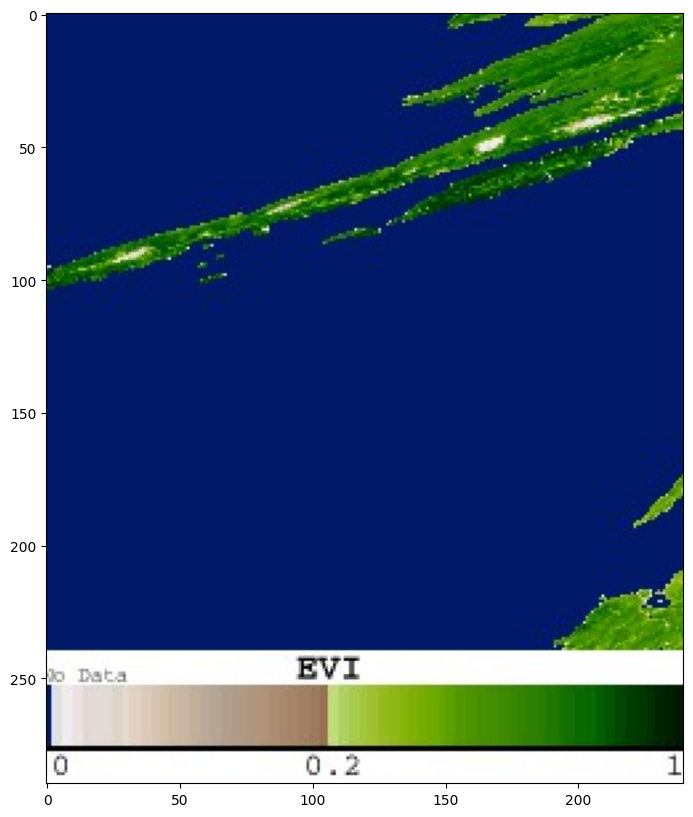

In [21]:
# Subset by Band

v = vnp_items[3]

evi_band_links = []

# Define which HLS product is being accessed
if v['assets']['browse']['href'].split('/')[4] == 'MYD13Q1.v061':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in v['assets']: 
    if any(b == a for b in evi_bands):
        evi_band_links.append(v['assets'][a]['href'])
for e in evi_band_links: print(e)

image = io.imread(v['assets']['browse']['href'])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

del image # Remove the browse image

In [8]:
# AUTHENTICATION CONFIGURATION
from netrc import netrc
from subprocess import Popen, DEVNULL, STDOUT
from getpass import getpass
from sys import platform

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

# Determine if netrc file exists, and if it includes NASA Earthdata Login Credentials
if 'win' in platform:
    nrc = '_netrc'
else:
    nrc = '.netrc'
try:
    netrcDir = os.path.expanduser(f"~/{nrc}")
    netrc(netrcDir).authenticators(urs)[0]
    del netrcDir

# If not, create a netrc file and prompt user for NASA Earthdata Login Username/Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")

    # Windows OS won't read the netrc unless this is set
    Popen(f'setx HOME {homeDir}', shell=True, stdout=DEVNULL);

    if nrc == '.netrc':
        Popen(f'touch {homeDir + os.sep}{nrc} | chmod og-rw {homeDir + os.sep}{nrc}', shell=True, stdout=DEVNULL, stderr=STDOUT);

    # Unable to use touch/chmod on Windows OS
    Popen(f'echo machine {urs} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo login {getpass(prompt=prompts[0])} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo password {getpass(prompt=prompts[1])} >> {homeDir + os.sep}{nrc}', shell=True)
    del homeDir

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen(f'echo machine {urs} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo login {getpass(prompt=prompts[0])} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo password {getpass(prompt=prompts[1])} >> {homeDir + os.sep}{nrc}', shell=True)
    del homeDir
del urs, prompts

In [9]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
for e in evi_band_links:
    print(e)
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
        fmask = rio.open(e)
print("The COGs have been loaded into memory!")

The COGs have been loaded into memory!


In [10]:
geo_CRS = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)  # Source coordinate system of the ROI
utm = pyproj.Proj(nir.crs)                                                  # Destination coordinate system
project = pyproj.Transformer.from_proj(geo_CRS, utm)                        # Set up the transformation
fsUTM = transform(project.transform, fieldShape)                            # Apply reprojection

NameError: name 'nir' is not defined